In [13]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt

In [97]:
def F_kn(q0, q1, k, n, dag = False):#figure 3 of the XY paper. Different convention than fig.8 of the Ising paper? 
    if k!= 0 and dag == False:
        qml.PhaseShift(2*np.pi*k/n, wires = q0) #This is an S gate for k = 1 n = 2
    if k!=0 and dag == True:
        qml.PhaseShift(-2*np.pi*k/n, wires = q0) #dagger
    
    qml.CNOT(wires = [q0, q1])
    qml.ctrl(qml.Hadamard, control = q1)(q0)
    qml.CNOT(wires = [q0, q1])
    qml.CZ(wires = [q0, q1])

n_qubits = 2
dev = qml.device("default.qubit", wires = n_qubits)
@qml.qnode(dev)
def test():
    F_kn(0, 1, k = 0, n = 8, dag = False)
    return qml.state()

qml.matrix(test)()

array([[ 1.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.707,  0.707,  0.   ],
       [ 0.   ,  0.707, -0.707,  0.   ],
       [ 0.   ,  0.   ,  0.   , -1.   ]])

In [98]:
def theta_k(h, n, k): #the only place where h comes in is theta which determines how much the modes are mixed in the bogoliubov transform
    return np.arccos((-h + np.cos(2 * np.pi * k / n)) /
                      np.sqrt((h - np.cos(2 * np.pi * k / n))**2 + np.sin(2 * np.pi * k / n)**2))
    
    # return np.arccos((h - np.cos(2 * np.pi * k / n)) /
    #                    np.sqrt((h - np.cos(2 * np.pi * k / n))**2 + np.sin(2 * np.pi * k / n)**2))

    
def B_kn(q0, q1, k, n, h, dag = False):
    J = 1 #exchange param
    g = 1 #anistropy parameter. gamma = 1 for ising
    
    #num = J*g*np.sin(2*np.pi*k/n)
    #den = h + J*np.cos(2*np.pi*k/n)
    
    #thetak = np.arctan(num/den) 
    #thetak = np.arctan2(num, den)#
    thetak = theta_k(h, n, k) #This one doesnt give the correct result at k =0 h <1 which doesn't matter in the other paper bc they say oh its identity and dont include it. Yet why if I include it do I still get the correct result for n = 4 in the XY paper?
    
    qml.CNOT(wires = [q0, q1])
    qml.X(wires = q1)
    if dag == False:
        qml.CRX(-thetak, wires = [q1, q0]) 
    else:
        qml.adjoint(qml.CRX(-thetak, wires = [q1, q0]))
    
    qml.X(wires = q1)
    qml.CNOT(wires = [q0, q1])

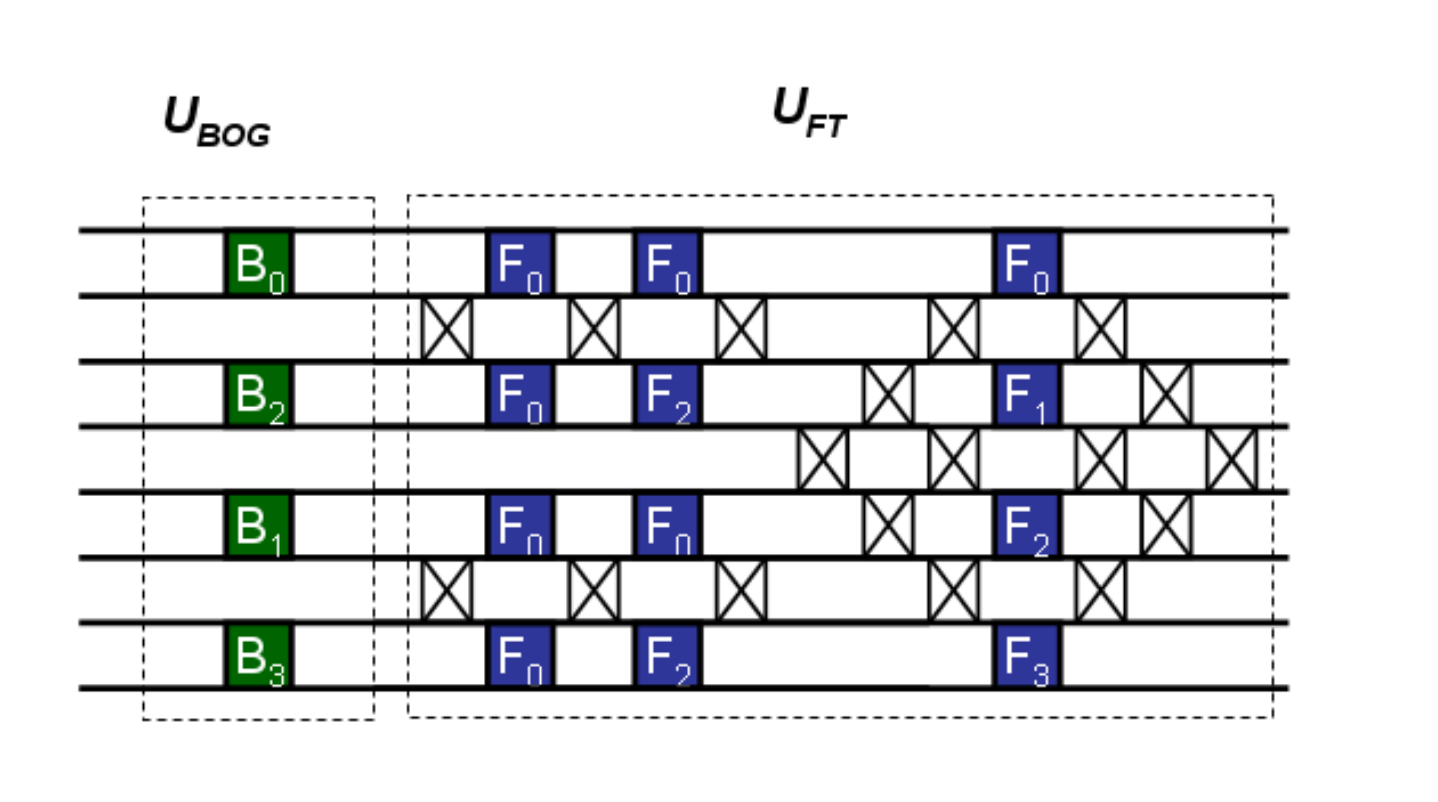

In [99]:
def Udis(h, dag = True): 
    B_kn(0, 1, 0, 8, h, dag = dag)
    B_kn(2, 3, 2, 8, h, dag = dag)
    B_kn(4, 5, 1, 8, h, dag = dag)
    B_kn(6, 7, 3, 8, h, dag = dag)

    qml.FermionicSWAP(phi = np.pi, wires = [1,2])
    qml.FermionicSWAP(phi = np.pi, wires = [5,6])

    F_kn(0, 1, k = 0, n = 8, dag = dag)
    F_kn(2, 3, k = 0, n = 8, dag = dag)
    F_kn(4, 5, k = 0, n = 8, dag = dag)
    F_kn(6, 7, k = 0, n = 8, dag = dag)

    qml.FermionicSWAP(phi = np.pi, wires = [1,2])
    qml.FermionicSWAP(phi = np.pi, wires = [5,6])

    F_kn(0, 1, k = 0, n = 8, dag = dag) #n = 8? so k = 2/ n = 8 same as k = 1 / n = 4
    F_kn(2, 3, k = 2, n = 8, dag = dag) #n = 8?
    F_kn(4, 5, k = 0, n = 8, dag = dag) #n = 8?
    F_kn(6, 7, k = 2, n = 8, dag = dag) #n = 8?

    qml.FermionicSWAP(phi = np.pi, wires = [1,2])
    qml.FermionicSWAP(phi = np.pi, wires = [5,6])

    qml.FermionicSWAP(phi = np.pi, wires = [3,4])
    
    qml.FermionicSWAP(phi = np.pi, wires = [2,3])
    qml.FermionicSWAP(phi = np.pi, wires = [4,5])
    
    qml.FermionicSWAP(phi = np.pi, wires = [1,2])
    qml.FermionicSWAP(phi = np.pi, wires = [3,4])
    qml.FermionicSWAP(phi = np.pi, wires = [5,6])
    

    F_kn(0, 1, k = 0, n = 8, dag = dag)
    F_kn(2, 3, k = 1, n = 8, dag = dag)
    F_kn(4, 5, k = 2, n = 8, dag = dag)
    F_kn(6, 7, k = 3, n = 8, dag = dag)

    qml.FermionicSWAP(phi = np.pi, wires = [1,2])
    qml.FermionicSWAP(phi = np.pi, wires = [3,4])
    qml.FermionicSWAP(phi = np.pi, wires = [5,6])

    qml.FermionicSWAP(phi = np.pi, wires = [2,3])
    qml.FermionicSWAP(phi = np.pi, wires = [4,5])

    qml.FermionicSWAP(phi = np.pi, wires = [3,4])

    

In [106]:
def Ising(h):
     #The discontinuity comes from here really
    if h <= 1: #otherwise prepare the state in |0001> #odd sector. #PBC after JW?
        qml.PauliX(wires = 1)

    for i in range(8):
        qml.X(wires = i)
    Udis(h, dag = False)

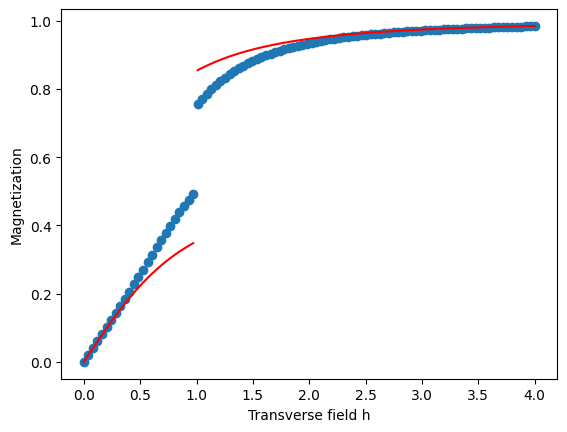

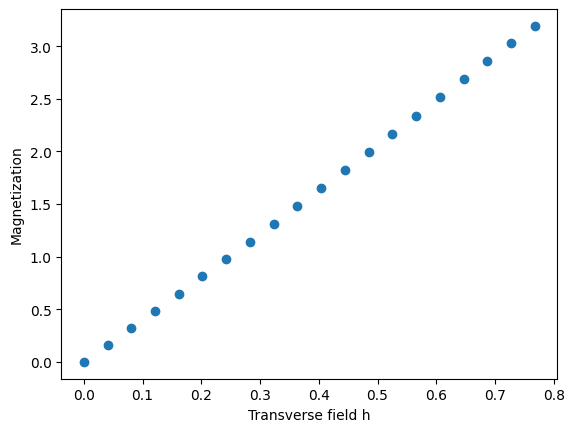

In [107]:
n_qubits = 8
dev = qml.device("default.qubit", wires = n_qubits)
@qml.qnode(dev)
def obs(h, observables): #Create Ising groundstates following method from Cervera-Lierta arXiv:1807.07112
    Ising(h)
    return [qml.expval(o) for o in observables]

obs_list = [qml.PauliZ(i) for i in range(n_qubits)]

h_values = np.linspace(0, 4, 100)

mag_arr = []
for h in h_values:
    mag = np.sum(obs(h, obs_list))
    mag_arr.append(mag)

def low_h(h):
    return h/(2*np.sqrt(1 + h**2))

def high_h(h):
    return 0.5 + h/(2*np.sqrt(1 + h**2))


plt.scatter(h_values, np.array(mag_arr)/8)
plt.plot(h_values[0:25],  low_h(h_values[0:25]), color = 'red')
plt.plot(h_values[25:], high_h(h_values[25:]), color = 'red')
plt.ylabel("Magnetization")
plt.xlabel("Transverse field h")
plt.show()

plt.scatter(h_values[:20], np.array(mag_arr)[:20])
plt.ylabel("Magnetization")
plt.xlabel("Transverse field h")
plt.show()